## Cone Classification Using Optical Feedback

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## simulation imports
from cone import *
import opticalfeedback

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<IPython.core.display.Javascript object>


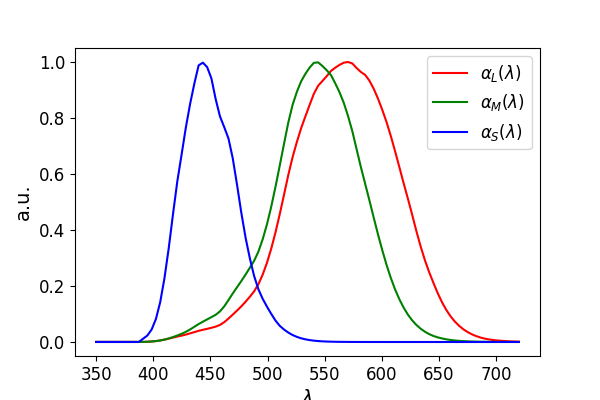

In [2]:
%matplotlib notebook
lmbdas = np.linspace(350,720,100)
lmbda = 625
c = cone('data/linss2_10e_fine.csv')

cL = list(map(c.cone_L,lmbdas))
cM = list(map(c.cone_M,lmbdas))
cS = list(map(c.cone_S,lmbdas))

fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=100)
ax.plot(lmbdas,cL, 'red', label=r'$\alpha_{L}(\lambda)$')
ax.plot(lmbdas,cM, 'green', label=r'$\alpha_{M}(\lambda)$')
ax.plot(lmbdas,cS, 'blue', label=r'$\alpha_{S}(\lambda)$')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('a.u.')
ax.legend()

## Demonstrate photopigment bleaching dynamics

In [3]:
%matplotlib notebook
n_on = 5
n_off = 195
pulse = ([1]*n_on) + ([0]*n_off)
pulse = pulse * 4
pulse = np.array(pulse)

step_size = 0.05
n_seconds = 40
t = np.arange(0, n_seconds, step_size)
p0 = 1.0
Qe = 3e6
Iin = 4e4*pulse
a_cone = c.cone_L(lmbda)
a_scatter = 0.95

Iout = []
pt = [p0]
p_ti = p0
for i, ti in enumerate(t):
    p_grad = dpdt(Iin[i], a_cone, Qe, pt[i])
    p_ti += p_grad * step_size
    pt.append(p_ti)
    Iout.append(compute_reflected_light(Iin[i], a_cone=a_cone, p_conc=p_ti, a_scatter=a_scatter))

In [4]:
a_cone

0.479941

<IPython.core.display.Javascript object>


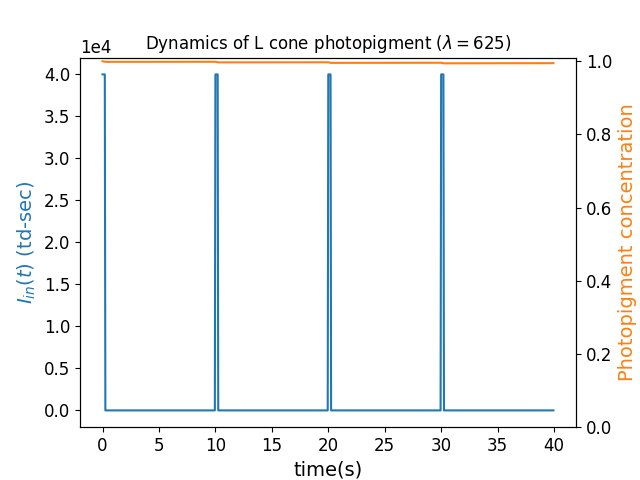

(0.0, 1.01)

In [5]:
fig,ax = plt.subplots()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(t, Iin, 'tab:blue')
ax.set_xlabel('time(s)')
ax.set_ylabel('$I_{in}(t)$ (td-sec)',color='tab:blue')
plt.title('Dynamics of L cone photopigment ($\lambda=%d$)'%(lmbda))

ax2=ax.twinx()
ax2.plot(t, pt[:-1],'tab:orange')
ax2.set_ylabel("Photopigment concentration",color='tab:orange')
ax2.set_ylim(bottom=0,top=1.01) 


<IPython.core.display.Javascript object>


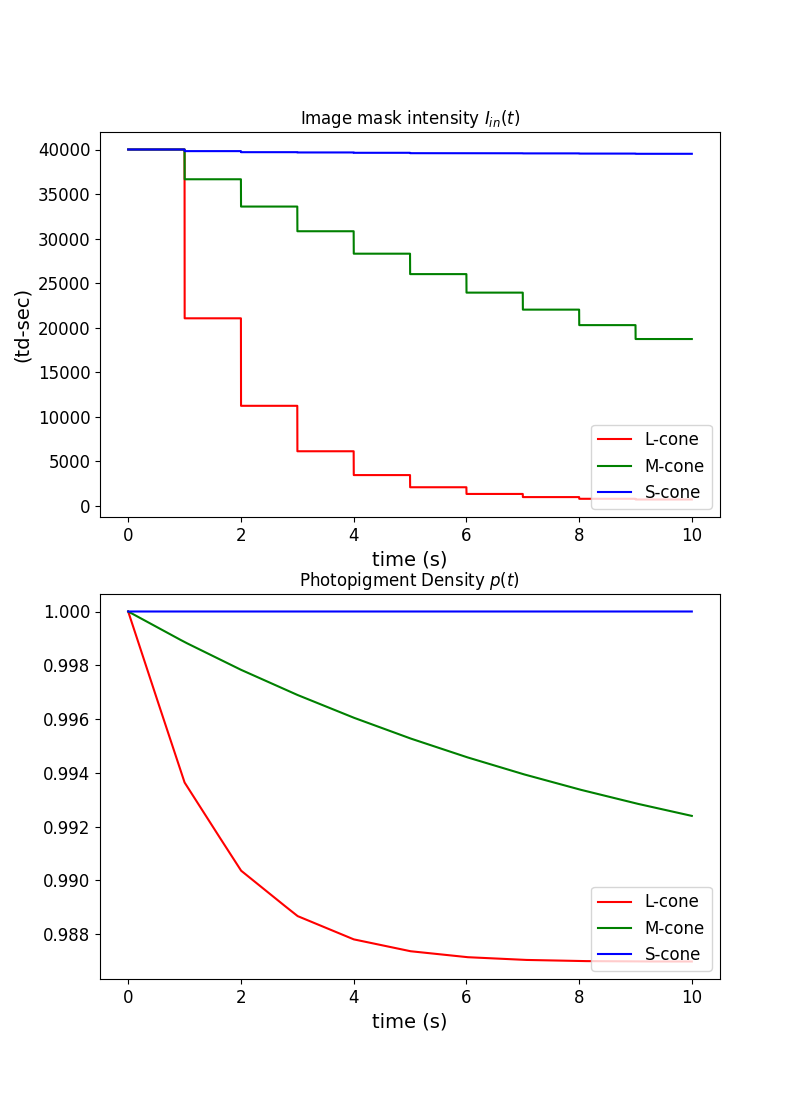

<IPython.core.display.Javascript object>


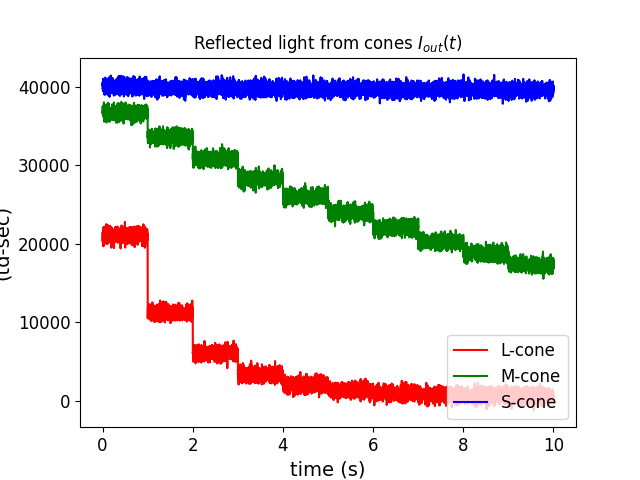

In [6]:
%matplotlib notebook


n_seconds   = 10     
a_scatter   = .995
Iin_0       = 4e4
update_rate = 1

L_Iin, L_Iout, L_pt, t, _,_ = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), 
                                                     n_seconds=n_seconds,
                                                     a_scatter_bounds=(a_scatter,a_scatter), 
                                                     Iin_0=Iin_0,
                                                     update_rate = update_rate
                                                    )

M_Iin, M_Iout, M_pt, t, _,_ = opticalfeedback.simulate(a_cone=c.cone_M(lmbda), 
                                                     n_seconds=n_seconds,
                                                     a_scatter_bounds=(a_scatter,a_scatter), 
                                                     Iin_0=Iin_0,
                                                     update_rate = update_rate
                                                    )

S_Iin, S_Iout, S_pt, t, _,_ = opticalfeedback.simulate(a_cone=c.cone_S(lmbda), 
                                                     n_seconds=n_seconds,
                                                     a_scatter_bounds=(a_scatter,a_scatter), 
                                                     Iin_0=Iin_0,
                                                     update_rate = update_rate
                                                    )


plt.figure(figsize=(8, 11), dpi=100)
plt.subplot(2,1,1)
plt.plot(t, L_Iin[:-1],c='r')
plt.plot(t, M_Iin[:-1],c='g')
plt.plot(t, S_Iin[:-1],c='b')
plt.title('Image mask intensity $I_{in}(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.ylabel('(td-sec)')

plt.subplot(2,1,2)
plt.plot(t, L_pt[:-1],c='r')
plt.plot(t, M_pt[:-1],c='g')
plt.plot(t, S_pt[:-1],c='b')
plt.title('Photopigment Density $p(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.show()

plt.figure()
plt.plot(t, L_Iout,c='r')
plt.plot(t, M_Iout,c='g')
plt.plot(t, S_Iout,c='b')
plt.title('Reflected light from cones $I_{out}(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.ylabel('(td-sec)')
plt.show()

# New stuff
## Infering intrinsic scatter

Given, 
$$I_{out}(t) = \alpha_{scatter} [ 1-\alpha_{cone}(\lambda)\cdot p(t) ]\cdot I_{in}(t) + \epsilon_m$$
If each cone is bleached $p(t)\rightarrow 0$,
$$I_{out}(t) = \alpha_{scatter} \cdot I_{in}(t) + \epsilon_m$$
We know $I_{in}$ (it is constant)
$$\mathbb{E}\left[\alpha_{scatter} \cdot I_{in} + \epsilon_m\right]$$
$$\mathbb{E}\left[\alpha_{scatter} \cdot I_{in} \right] + \mathbb{E}\left[\epsilon_m\right]$$

Assume we know $\mathbb{E}\left[\epsilon_m\right]$, and have $t=\{1,2,3,...,T\}$ samples of $I_{out}(t)$ (a random variable), estimate scatter via,

$$\hat{\alpha}_{scatter} = \sum_{t=1}^T\frac{I_{out}(t)-\mathbb{E}[\epsilon_m]}{I_{in}}$$


Now, using this estimate, we update the stimulus update equation accordingly. 

$$I_{out}(t) = \alpha_{scatter} [ 1-(\alpha_{cone}+\epsilon_{cone})\cdot p(t) ] \cdot I_{in}(t) + \epsilon_{m}$$

$$I_{in}(t+1):= \frac{I_{out}(t) -\mathbb{E}[\epsilon_m]}{\hat{\alpha}_{scatter}}$$

In [7]:
# simple helper functions
def append_four(a, b, c, d, all_a, all_b, all_c, all_d):
    # append 4 values to 4 lists
    all_a.append(a)
    all_b.append(b)
    all_c.append(c)
    all_d.append(d)
    
    
def convert_to_np(a,b,c,d):
    # convert four arrays to np.arrays
    return np.asarray(a), np.asarray(b), np.asarray(c), np.asarray(d)

## Run experiment without $\alpha_{scatter}$ estimation

In [10]:
# simulation settings
n_cones = 25

L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]

for i in range(n_cones):
    L_Iin, L_Iout, L_pt, t, L_resid,_ = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), account_for_a_scatter=False, \
                                                               a_scatter_bounds=(0.2,1),update_rate = update_rate)
    M_Iin, M_Iout, M_pt, t, M_resid,_ = opticalfeedback.simulate(a_cone=c.cone_M(lmbda), account_for_a_scatter=False, \
                                                               a_scatter_bounds=(0.2,1),update_rate = update_rate)
    S_Iin, S_Iout, S_pt, t, S_resid,_ = opticalfeedback.simulate(a_cone=c.cone_S(lmbda), account_for_a_scatter=False, \
                                                               a_scatter_bounds=(0.2,1),update_rate = update_rate)
    append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
print('L-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(L_resid_all), np.std(L_resid_all)))
print('M-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(M_resid_all), np.std(M_resid_all)))
print('S-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(S_resid_all), np.std(S_resid_all)))

L-cone intrinsic residual ~ mean: 9.00e+09 ~ std: 0.00e+00
M-cone intrinsic residual ~ mean: 9.00e+09 ~ std: 0.00e+00
S-cone intrinsic residual ~ mean: 9.00e+09 ~ std: 0.00e+00


<IPython.core.display.Javascript object>


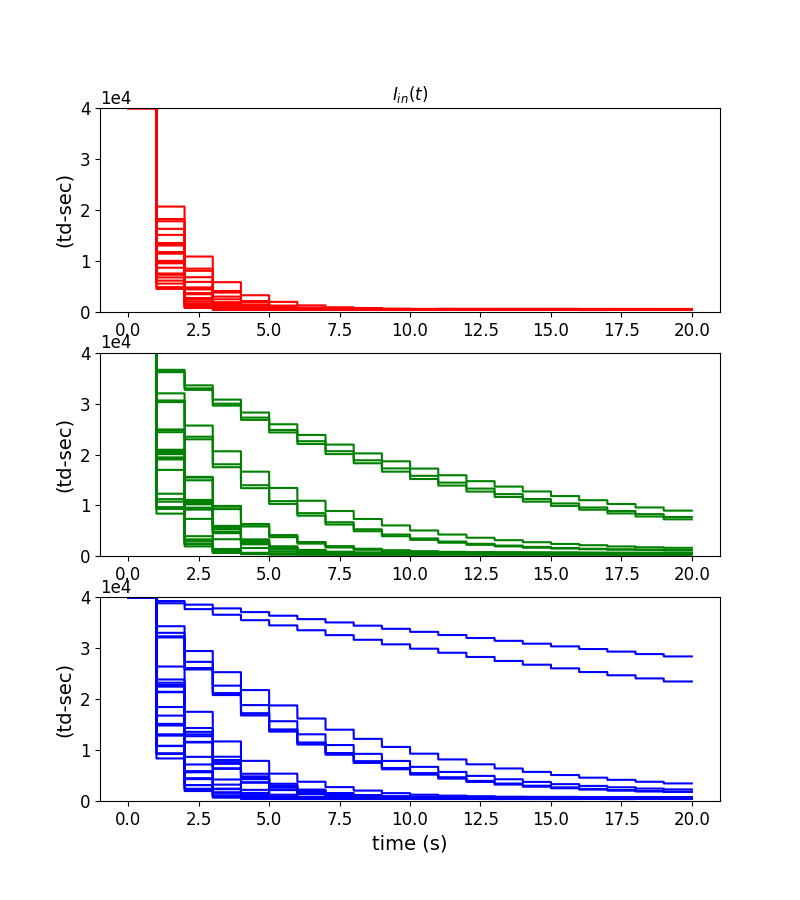

<IPython.core.display.Javascript object>


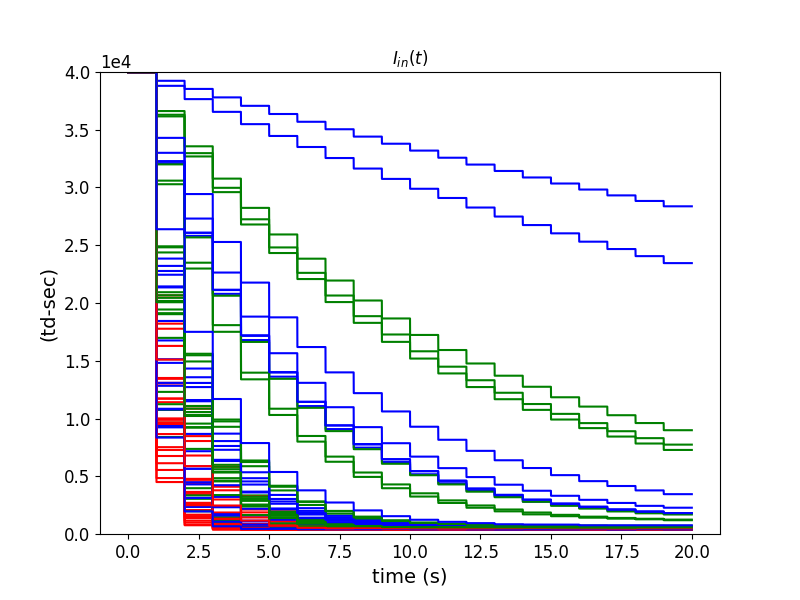

Text(0.5, 0, 'time (s)')

In [11]:
# qt, wx, gtk, osx, tk, empty uses default
%matplotlib notebook 

ylim = Iin_0

plt.figure(figsize=(8, 9), dpi=100)
plt.subplot(3,1,1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, M_Iin_all[i,:-1],c='g')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, S_Iin_all[i,:-1],c='b')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

plt.figure(figsize=(8, 6), dpi=100)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
    plt.plot(t, M_Iin_all[i,:-1],c='g')
    plt.plot(t, S_Iin_all[i,:-1],c='b')
    
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

## Run experiment with $\alpha_{scatter}$ estimation

In [12]:
# simulation settings
n_cones = 25

L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]

for i in range(n_cones):
    L_Iin, L_Iout, L_pt, t, L_resid, update_indices = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), account_for_a_scatter=True, \
                                                               a_scatter_bounds=(0.2,1), update_rate = update_rate)
    M_Iin, M_Iout, M_pt, t, M_resid, update_indices  = opticalfeedback.simulate(a_cone=c.cone_M(lmbda), account_for_a_scatter=True, \
                                                               a_scatter_bounds=(0.2,1), update_rate = update_rate)
    S_Iin, S_Iout, S_pt, t, S_resid, update_indices  = opticalfeedback.simulate(a_cone=c.cone_S(lmbda), account_for_a_scatter=True, \
                                                               a_scatter_bounds=(0.2,1), update_rate = update_rate)
    
    update_indices = np.array(update_indices)
    append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
print('L-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(L_resid_all), np.std(L_resid_all)))
print('M-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(M_resid_all), np.std(M_resid_all)))
print('S-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(S_resid_all), np.std(S_resid_all)))

L-cone intrinsic residual ~ mean: 8.89e-04 ~ std: 4.91e-04
M-cone intrinsic residual ~ mean: 8.19e-04 ~ std: 6.15e-04
S-cone intrinsic residual ~ mean: 8.52e-04 ~ std: 6.05e-04


<IPython.core.display.Javascript object>


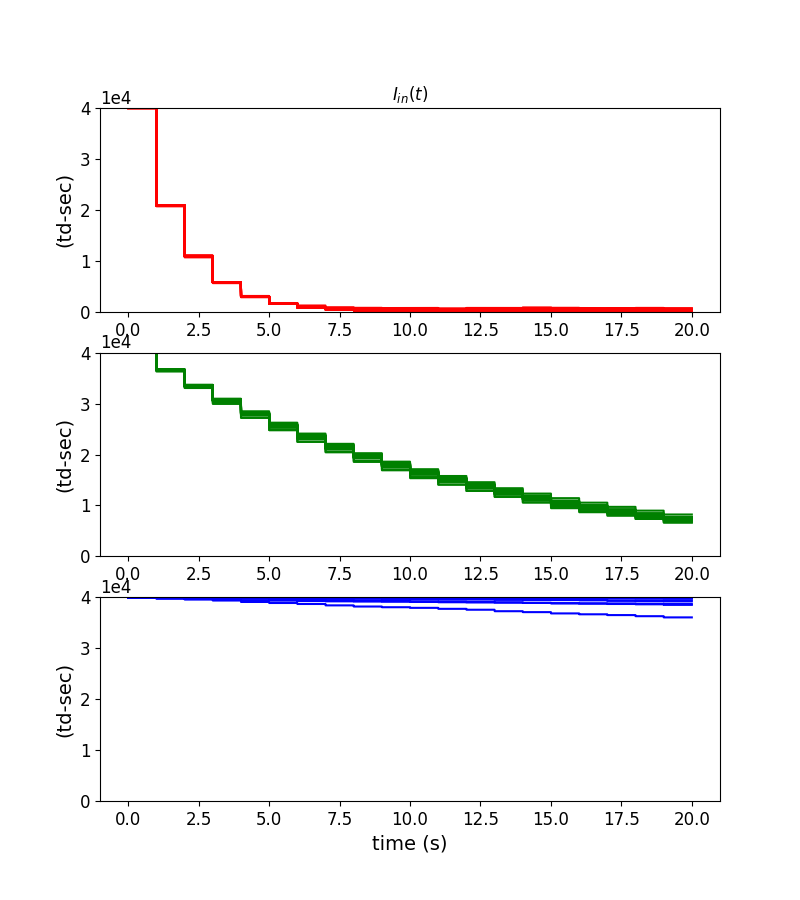

<IPython.core.display.Javascript object>


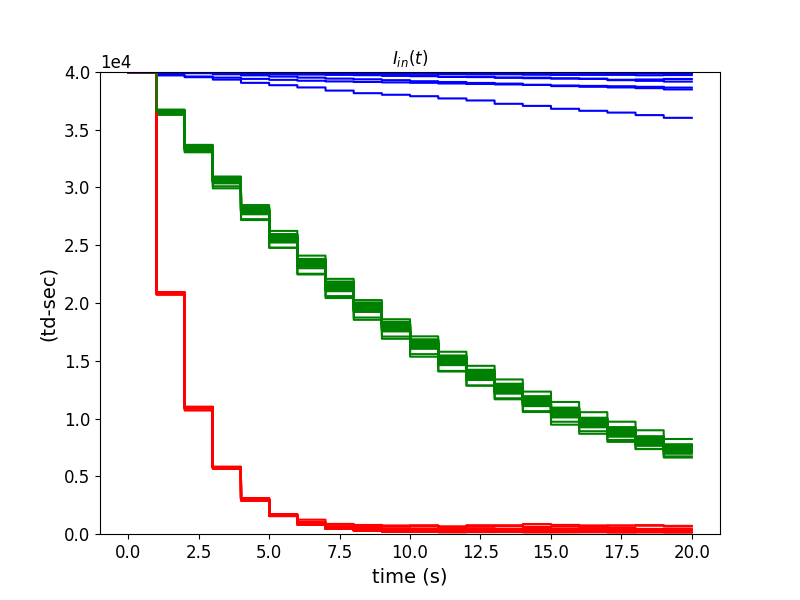

Text(0.5, 0, 'time (s)')

In [13]:
# qt, wx, gtk, osx, tk, empty uses default
%matplotlib notebook 

ylim = Iin_0

plt.figure(figsize=(8, 9), dpi=100)
plt.subplot(3,1,1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, M_Iin_all[i,:-1],c='g')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, S_Iin_all[i,:-1],c='b')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

plt.figure(figsize=(8, 6), dpi=100)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_cones):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
    plt.plot(t, M_Iin_all[i,:-1],c='g')
    plt.plot(t, S_Iin_all[i,:-1],c='b')
    
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

### In the above model, we see that correcting for the inherent scatter made the input image diverge from the other cones! This should allow us to cluster the curves and infer L-types easily.

<IPython.core.display.Javascript object>


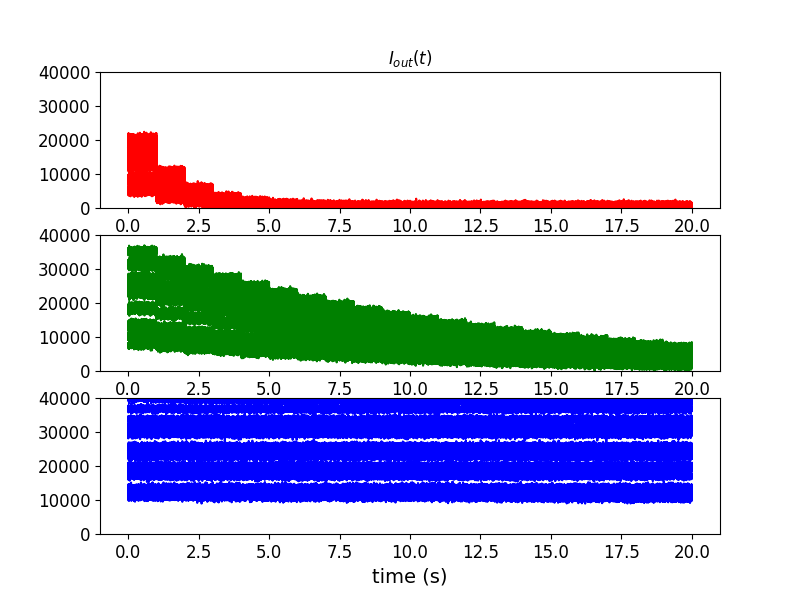

Text(0.5, 0, 'time (s)')

In [14]:
%matplotlib notebook

plt.figure(figsize=(8, 6), dpi=100)
plt.subplot(3,1,1)
for i in range(n_cones):
    plt.plot(t, L_Iout_all[i,:],c='r')
plt.ylim([0, Iin_0])
plt.title('$I_{out}(t)$')

plt.subplot(3,1,2)
for i in range(n_cones):
    plt.plot(t, M_Iout_all[i,:],c='g')
plt.ylim([0, Iin_0])
    
plt.subplot(3,1,3)
for i in range(n_cones):
    plt.plot(t, S_Iout_all[i,:],c='b')
plt.ylim([0, Iin_0])
plt.xlabel('time (s)')

<IPython.core.display.Javascript object>


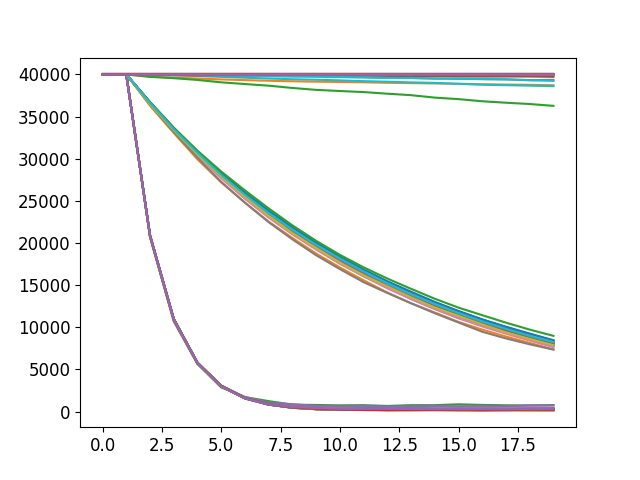

In [16]:
Iin_all = np.concatenate([L_Iin_all, M_Iin_all, S_Iin_all])
X = Iin_all[:,update_indices]

plt.figure()
plt.plot(X.T)
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [21]:
y = np.concatenate([[i]*25 for i in range(3)])

In [22]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [23]:
def relabel(yhat, lms_list):
    return lms_list.index(yhat)

In [24]:
def compute_overlap(yprob, lms_list):
    l = relabel(0, lms_list)
    m = relabel(1, lms_list)
    s = relabel(2, lms_list)
    lm_overlap = np.sum(np.prod(yprob[:,(l,m)], axis = 1))
    ms_overlap = np.sum(np.prod(yprob[:,(m,s)], axis = 1))
    ls_overlap = np.sum(np.prod(yprob[:,(l,s)], axis = 1))
    overlap = lm_overlap + ms_overlap + ls_overlap
    return overlap

In [78]:
num_observations = X.shape[1]
scores = []
accuracy = []
gms = []
overlaps = []
for i in range(num_observations):
    Xi = X[:,i].reshape(-1,1) + np.random.rand(*X[:,i].reshape(-1,1).shape)
    gm = GaussianMixture(n_components=3, random_state=0,n_init=5,tol=0.0001,max_iter=200,init_params='kmeans').fit(Xi)
    lms_list = list(np.argsort(gm.means_.reshape(-1)))
    scores.append(-gm.score(Xi))
    yhat = gm.predict(Xi)
    yprob = gm.predict_proba(Xi)
    overlaps.append(compute_overlap(yprob, lms_list))
    yhat = np.array([relabel(yi, lms_list) for yi in yhat])
    accuracy.append(np.mean(y == yhat))
    gms.append(gm)
    
        
best_index = np.argmin(overlaps)
best_gm = gms[best_index]

best_accuracy = accuracy[best_index]
total_time = t[-1]




In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from cone import *
import opticalfeedback

%matplotlib notebook
lmbdas = np.linspace(350,720,100)
lmbda = 625
c = cone('data/linss2_10e_fine.csv')

# simple helper functions
def append_four(a, b, c, d, all_a, all_b, all_c, all_d):
    # append 4 values to 4 lists
    all_a.append(a)
    all_b.append(b)
    all_c.append(c)
    all_d.append(d)
    
def convert_to_np(a,b,c,d):
    # convert four arrays to np.arrays
    return np.asarray(a), np.asarray(b), np.asarray(c), np.asarray(d)

# SIMULATE
# simulation settings
def run_experiment(update_rate, Iin_0, n_seconds=20, lmbda = 625, n_cones = 25, mu_m = 250, sigma_m = 500):
    L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
    M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
    S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]
    

#     scatter_est_duration = kwargs.pop('scatter_est_duration',5)
#     a_scatter_bounds = kwargs.pop('a_scatter_bounds',(1,1))

    for i in range(n_cones):
        L_Iin, L_Iout, L_pt, t, L_resid, update_indices = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), 
                                                                                   account_for_a_scatter=True,
                                                                                   a_scatter_bounds=(0.2,1), 
                                                                                   update_rate = update_rate, 
                                                                                   mu_m = 250, 
                                                                                   sigma_m = 500,
                                                                                   Iin_0 = Iin_0,
                                                                                   n_seconds=n_seconds
                                                                                  )
        M_Iin, M_Iout, M_pt, t, M_resid, update_indices  = opticalfeedback.simulate(a_cone=c.cone_M(lmbda),
                                                                                    account_for_a_scatter=True,
                                                                                    a_scatter_bounds=(0.2,1), 
                                                                                    update_rate = update_rate,
                                                                                    mu_m = 250, 
                                                                                    sigma_m = 500,
                                                                                    Iin_0 = Iin_0,
                                                                                    n_seconds=n_seconds
                                                                                  )
        S_Iin, S_Iout, S_pt, t, S_resid, update_indices  = opticalfeedback.simulate(a_cone=c.cone_S(lmbda),
                                                                                    account_for_a_scatter=True,
                                                                                    a_scatter_bounds=(0.2,1), 
                                                                                    update_rate = update_rate,
                                                                                    mu_m = 250, 
                                                                                    sigma_m = 500,
                                                                                    Iin_0 = Iin_0,
                                                                                    n_seconds=n_seconds
                                                                                   )

        update_indices = np.array(update_indices)
        append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
        append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
        append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)

    L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)

    ### Format outputs for classification    
    Iin_all = np.concatenate([L_Iin_all, M_Iin_all, S_Iin_all])
    X = Iin_all[:,update_indices]
    y = np.concatenate([[i]*n_cones for i in range(3)])

    return X, y

def relabel(yhat, lms_list):
    return lms_list.index(yhat)

def compute_overlap(yprob, lms_list):
    l = relabel(0, lms_list)
    m = relabel(1, lms_list)
    s = relabel(2, lms_list)
    lm_overlap = np.sum(np.prod(yprob[:,(l,m)], axis = 1))
    ms_overlap = np.sum(np.prod(yprob[:,(m,s)], axis = 1))
    ls_overlap = np.sum(np.prod(yprob[:,(l,s)], axis = 1))
    overlap = lm_overlap + ms_overlap + ls_overlap
    return overlap

    

def compute_accuracy(X,y):
    '''Compute the prediction accuracy for a given experiment.'''
    X = np.array(X)
    y = np.array(y)
    num_observations = X.shape[1]
    scores = []
    accuracy = []
    gms = []
    overlaps = []
    for i in range(num_observations):
        Xi = X[:,i].reshape(-1,1) + np.random.rand(*X[:,i].reshape(-1,1).shape)
        gm = GaussianMixture(n_components=3, random_state=0,n_init=5,tol=0.0001,max_iter=200,init_params='kmeans').fit(Xi)
        lms_list = list(np.argsort(gm.means_.reshape(-1)))
        scores.append(-gm.score(Xi))
        yhat = gm.predict(Xi)
        yprob = gm.predict_proba(Xi)
        overlaps.append(compute_overlap(yprob, lms_list))
        yhat = np.array([relabel(yi, lms_list) for yi in yhat])
        accuracy.append(np.mean(y == yhat))
        gms.append(gm)


    best_index = np.argmin(overlaps)
    best_gm = gms[best_index]

    best_accuracy = accuracy[best_index]

    return best_accuracy

In [148]:
X.shape

(75, 50)

In [83]:
# class AccuracyFunction:
#     def __init__(self):
#         self.prev_value = None
        
#     def compute_accuracy_memo(self,X,y):
#         if self.prev_value is not None:
#             returned_value = self.prev_value
#             self.prev_value = None
#             return returned_value
#         else:
#             answer = self.compute_accuracy(X,y)
#             self.prev_value = answer
#             return answer

In [190]:
# global accfunc
# accfunc = AccuracyFunction()
prev_accuracy = None

def L(intensity, rate, num_steps, print_vars = False):
    Iin_0 = intensity
    update_rate = rate
    n_seconds = update_rate * num_steps
#     pdb.set_trace()
    # Run experiment
    X,y = run_experiment(update_rate=update_rate, Iin_0=Iin_0, n_seconds=n_seconds)#, lmbda = 625, n_cones = 25, mu_m = 250, sigma_m = 500)

    # Classify Cones
    # Compute accuracy
    acc = compute_accuracy(X,y)
    global prev_accuracy
    prev_accuracy = acc
    
    if print_vars:
        print('Iin: {}'.format(Iin_0))
        print('rate: {}'.format(update_rate))
        print('num_steps: {}'.format(num_steps))
        print('Acc: {}'.format(acc))
        print('n_seconds: {}'.format(n_seconds))
    return n_seconds, acc, X, y

In [191]:
L(4e4,0.1,1)

(0.1,
 0.3333333333333333,
 array([[40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
        [40000.],
 

In [135]:
print(prev_accuracy)

0.36


In [142]:
from scipy import optimize


def accuracy_constraint(x, lb=0.95):
    return prev_accuracy - lb
    

#function to minimize
def f(x):
    update_rate = x[0]
    Iin         = x[1] * 4e6
    num_steps   = x[2]
    accuracy    = x[3]
    
    return L(intensity = Iin, rate = update_rate, num_steps = num_steps)

#initial values
initial_point=[5,0.5,10,0.82]    # [update_rate(Hz), Iin, num_steps, accuracy]
#lower and upper bound for first three variables
bounds=[ [0.2,10],[0,1],[1,100]]

#construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    
# add contraint for accuracy
l = {'type': 'ineq',
     'fun': accuracy_constraint}
cons.append(l)

#run optimization
# res = optimize.minimize(f,initial_point,constraints=cons,method='COBYLA',options={'maxiter':1e4, 'disp':True,'catol': 0.001})
res = optimize.minimize(f,initial_point,constraints=cons,method='',options={'maxiter':1e4, 'disp':True,'catol': 0.001})

print(res)

Iin: 2000000.0
rate: 5.0
num_steps: 10.0
Acc: 1.0
n_seconds: 50.0
Iin: 2000000.0
rate: 6.0
num_steps: 10.0
Acc: 1.0
n_seconds: 60.0
Iin: 6000000.0
rate: 5.0
num_steps: 10.0
Acc: 1.0
n_seconds: 50.0
Iin: 2000000.0
rate: 5.0
num_steps: 11.0
Acc: 1.0
n_seconds: 55.0
Iin: 2000000.0
rate: 5.0
num_steps: 10.0
Acc: 1.0
n_seconds: 50.0
Iin: 2000000.0
rate: 4.105572809000084
num_steps: 9.552786404500042
Acc: 1.0
n_seconds: 39.21966011250105
Iin: 2000000.0
rate: 3.2195949127898853
num_steps: 9.089058933427916
Acc: 1.0
n_seconds: 29.26308790411198
Iin: 1663688.6977956349
rate: 2.412186036419321
num_steps: 8.511172487091594
Acc: 1.0
n_seconds: 20.530531426918646
Iin: -4.440892098500626e-10
rate: 2.5885215060234112
num_steps: 7.784665906325973
Acc: 0.3333333333333333
n_seconds: 20.15077511573201
Iin: 70761.2833424969
rate: 2.4510698742036108
num_steps: 8.03389088040251
Acc: 1.0
n_seconds: 19.691627909593716
Iin: 8.326672684688674e-11
rate: 1.4741112596872554
num_steps: 7.83602084989585
Acc: 0.30666

In [151]:
res

     fun: 1.455526306566291
   maxcv: 0.5233333333333332
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 53
  status: 4
 success: False
       x: array([ 0.15091742, -0.2295854 ,  9.64452161,  0.1500228 ])

In [156]:
intensities.size

10

In [171]:
intensities = np.linspace(4e3,4e5,9)
rates = np.linspace(0.1,1,10)
times = np.zeros((intensities.size, rates.size))
accs = np.zeros((intensities.size, rates.size))

for i, intensity in enumerate(intensities):
    for j, rate in enumerate(rates):
        for num_steps in [50]:
            time, acc = L(intensity, rate, num_steps)
            times[i,j] = time
            accs[i,j] = acc

Iin: 4000.0
rate: 0.1
num_steps: 50
Acc: 0.7466666666666667
n_seconds: 5.0
Iin: 4000.0
rate: 0.2
num_steps: 50
Acc: 0.9733333333333334
n_seconds: 10.0
Iin: 4000.0
rate: 0.30000000000000004
num_steps: 50
Acc: 0.9333333333333333
n_seconds: 15.000000000000002
Iin: 4000.0
rate: 0.4
num_steps: 50
Acc: 0.9333333333333333
n_seconds: 20.0
Iin: 4000.0
rate: 0.5
num_steps: 50
Acc: 0.96
n_seconds: 25.0
Iin: 4000.0
rate: 0.6
num_steps: 50
Acc: 0.96
n_seconds: 30.0
Iin: 4000.0
rate: 0.7000000000000001
num_steps: 50
Acc: 0.9866666666666667
n_seconds: 35.0
Iin: 4000.0
rate: 0.8
num_steps: 50
Acc: 0.8133333333333334
n_seconds: 40.0
Iin: 4000.0
rate: 0.9
num_steps: 50
Acc: 0.9466666666666667
n_seconds: 45.0
Iin: 4000.0
rate: 1.0
num_steps: 50
Acc: 0.44
n_seconds: 50.0
Iin: 53500.0
rate: 0.1
num_steps: 50
Acc: 1.0
n_seconds: 5.0
Iin: 53500.0
rate: 0.2
num_steps: 50
Acc: 1.0
n_seconds: 10.0
Iin: 53500.0
rate: 0.30000000000000004
num_steps: 50
Acc: 1.0
n_seconds: 15.000000000000002
Iin: 53500.0
rate: 0.4


In [180]:
intensities

array([  4000.,  53500., 103000., 152500., 202000., 251500., 301000.,
       350500., 400000.])

<IPython.core.display.Javascript object>


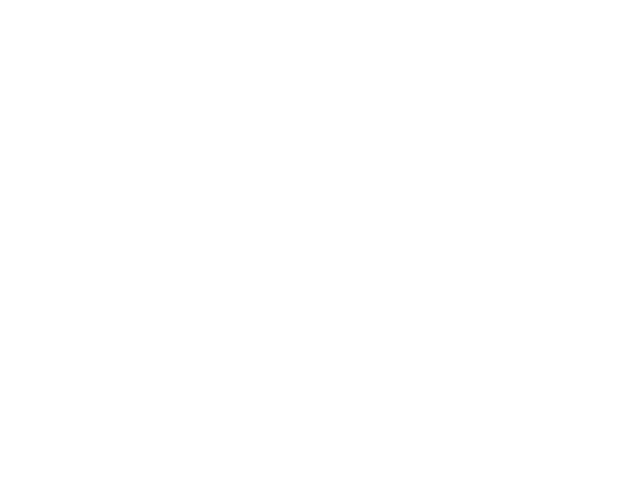

<IPython.core.display.Javascript object>


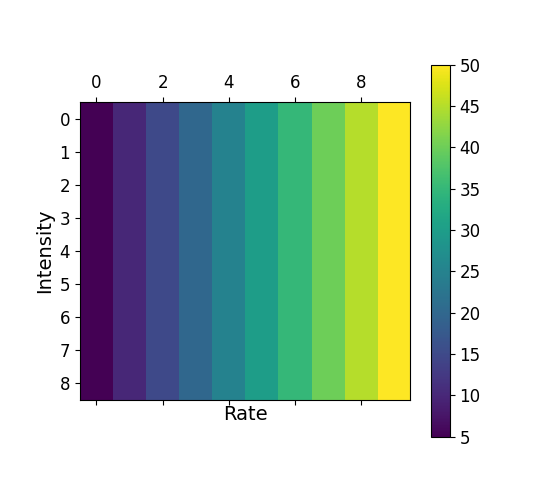

In [178]:
plt.figure()
plt.matshow(times)# ,extent=[rates[0],rates[-1],intensities[0],intensities[-1]])
plt.xlabel('Rate')
plt.ylabel('Intensity')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


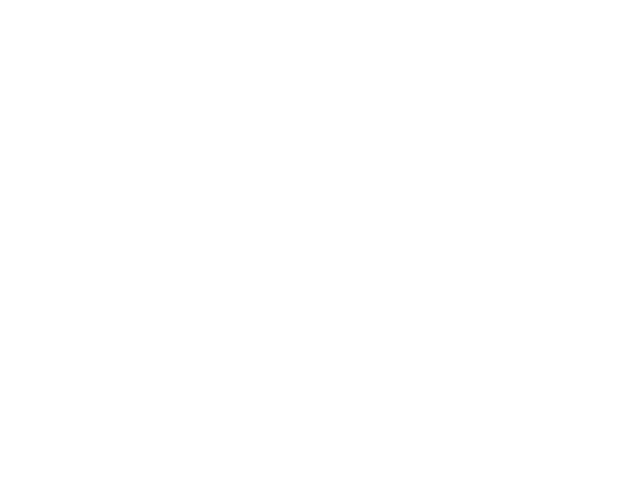

<IPython.core.display.Javascript object>


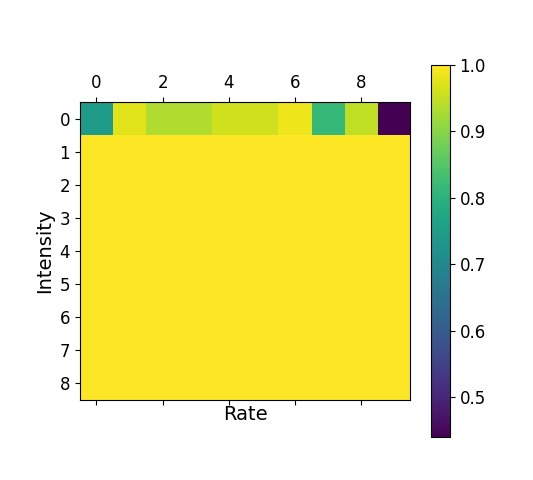

In [179]:
plt.figure()
plt.matshow(accs)#,extent=[rates[0],rates[-1],intensities[0],intensities[-1]])
plt.xlabel('Rate')
plt.ylabel('Intensity')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


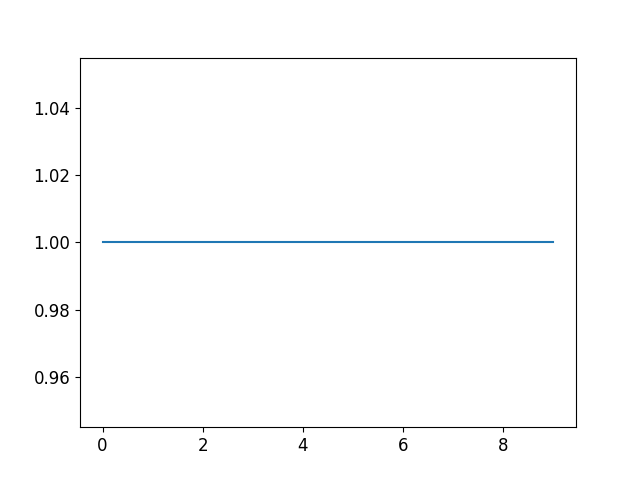

<function matplotlib.pyplot.show(block=None)>

In [189]:
rates = np.linspace(0.01,0.1,10)
intensity = 4e4
num_steps = 6
accs = [L(intensity, rate, num_steps)[1] for rate in rates]

plt.figure()
plt.plot(accs)
plt.show

In [120]:
result

{'i_400.0_r_1_ns_5': (5, 0.49333333333333335),
 'i_400.0_r_1_ns_10': (10, 0.52),
 'i_4000.0_r_1_ns_5': (5, 0.96),
 'i_4000.0_r_1_ns_10': (10, 0.96)}

In [76]:
import pdb


In [ ]:
from scipy import optimize


def compute_accuracy(x,lb=0.9):
    # feed forward experiment with x...
    # ...
    accuracy = x[3]
    return accuracy - lb
    

#function to minimize
def f(x):
    update_rate = x[0]
    Iin         = x[1] * 4e6
    num_steps   = x[2]
    accuracy    = x[3]
    return  update_rate/10 - Iin/4e6 + num_steps/1000 + accuracy/1.

#initial values
initial_point=[10,9e5,100,.95]    # [update_rate(Hz), Iin, num_steps, accuracy]
#lower and upper bound for first three variables
bounds=[ [0.2,10],[0,1],[1,1000]]

#construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    
# add contraint for accuracy
l = {'type': 'ineq',
     'fun': compute_accuracy}
cons.append(l)

#run optimization
res = optimize.minimize(f,initial_point,constraints=cons,method='COBYLA',options={'maxiter':1e7})

print(res)

In [56]:
L(4e4, 0.1, 20)

1.0


39.95

<IPython.core.display.Javascript object>


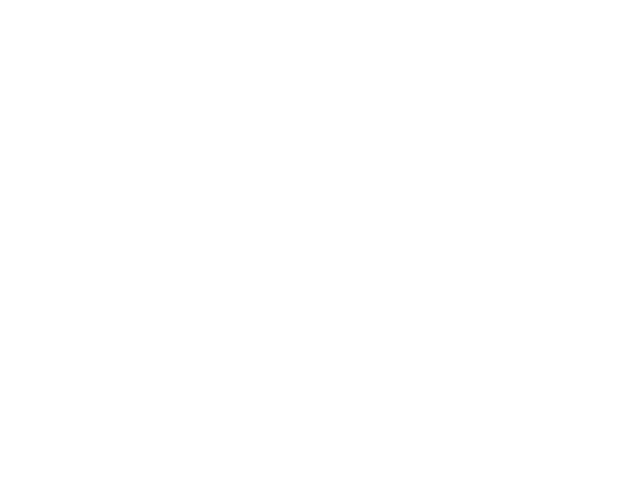

NameError: name 'overlaps' is not defined

In [40]:
plt.figure()
plt.plot(overlaps)
plt.show()

<IPython.core.display.Javascript object>


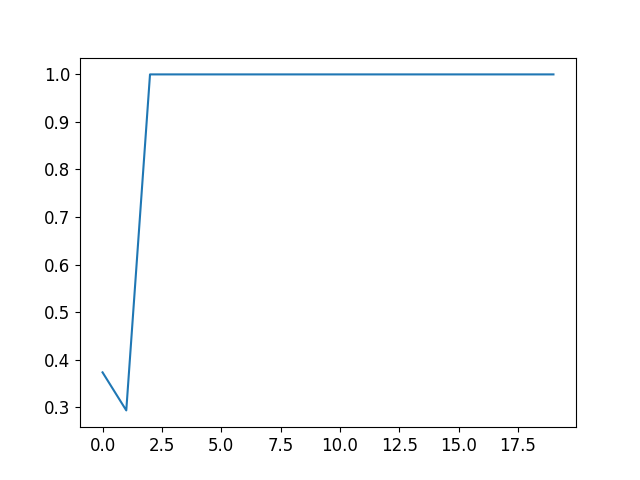

In [45]:
plt.figure()
plt.plot(accuracy)
plt.show()

In [47]:
from scipy.stats import norm

In [48]:
index = 2
Xi = X[:,index].reshape(-1,1)
# Xs = Xi[gm.predict(Xi) == s]
# Xm = Xi[gm.predict(Xi) == m]
# Xl = Xi[gm.predict(Xi) == l]

Xs = Xi[y == 2]
Xm = Xi[y == 1]
Xl = Xi[y == 0]

<IPython.core.display.Javascript object>


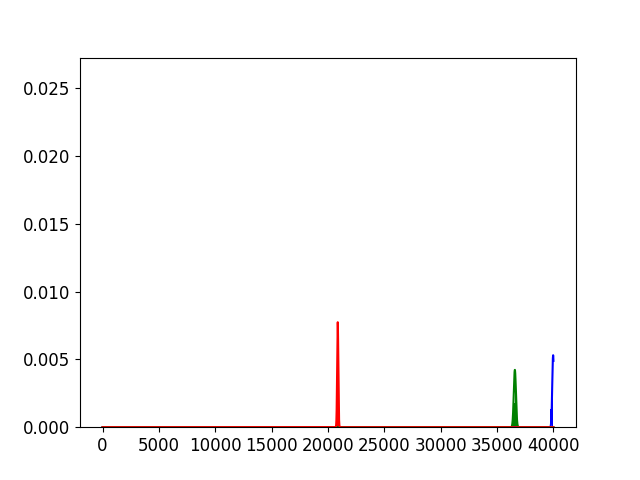

In [63]:
plt.figure()

plt.hist(Xs,density = True,color='blue')
plt.hist(Xm,density = True,color='green')
plt.hist(Xl,density = True,color='red')
ttt = np.arange(0,Iin_0,.1)

gm_index = gms[index]
l,m,s = np.argsort(gm_index.means_.reshape(-1))
plt.plot(ttt,norm.pdf(ttt, gm_index.means_[s], np.sqrt(gm_index.covariances_[s])).reshape(-1), c = 'blue')
plt.plot(ttt,norm.pdf(ttt, gm_index.means_[m], np.sqrt(gm_index.covariances_[m])).reshape(-1), c = 'green')
plt.plot(ttt,norm.pdf(ttt, gm_index.means_[l], np.sqrt(gm_index.covariances_[l])).reshape(-1), c = 'red')

plt.show()

In [64]:
np.sum(norm.pdf(ttt, gm_index.means_[l], np.sqrt(gm_index.covariances_[l])).reshape(-1))*ttt[1]

1.0

In [54]:
norm.pdf?

--------

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
# X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
X = np.concatenate([np.random.normal(4,0.5,100), np.random.normal(0,0.1,80)]).reshape(-1,1)
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

In [42]:
np.exp(-gm.score(X))

1.897737541866749

In [43]:
X = np.concatenate([np.random.normal(4,0.5,100), np.random.normal(3,0.1,80)]).reshape(-1,1)
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

In [44]:
np.exp(-gm.score(X))

1.7210798147235207

In [36]:
X.shape

(180, 1)

In [37]:
gm.means_

array([[3.01972681],
       [4.02706894]])

(array([46., 38.,  6., 10., 20., 26., 20.,  3.,  7.,  4.]),
 array([2.80530111, 3.0265348 , 3.24776848, 3.46900217, 3.69023586,
        3.91146955, 4.13270324, 4.35393693, 4.57517062, 4.79640431,
        5.017638  ]),
 <BarContainer object of 10 artists>)

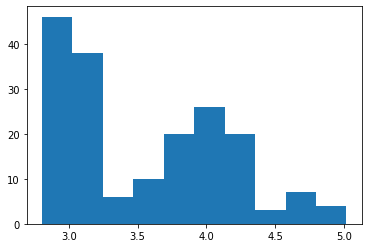

In [25]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(gm.means_[:,0],gm.means_[:,1])
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [3]:
gm.means_

array([[10.,  2.],
       [ 1.,  2.]])